In [1]:
import os
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.tree import export_graphviz
import lightgbm as lgb
from catboost import CatBoostRegressor
import scipy as sp
from scipy.fftpack import fft
from tsfresh.feature_extraction import feature_calculators

from scipy import signal

import gc
%matplotlib inline

In [2]:
def load_extracted_features(features_file):
    train_X = pd.read_csv(os.path.join("../extracted_feat/",features_file))
    train_y = pd.read_csv(os.path.join("../extracted_feat/",'train_y_11.csv'))
    return train_X,train_y
def load_extracted_test(features_file):
    segment_names = [file[:-4] for file in os.listdir("../input") if file.startswith("seg")]
    test_df = pd.read_csv(os.path.join("../extracted_feat/",features_file))
    test_df.index = segment_names
    return test_df

In [3]:
train_X,train_y = load_extracted_features("train_58.csv")
test_df = load_extracted_test("test_58.csv")

In [4]:
#eliminate quakes from training
quakes = (train_y["time_to_failure"] - train_y["time_to_failure"].shift())>0.5

train_y_eliminated = train_y[~quakes].copy()
train_X_eliminated = train_X[~quakes].copy()

In [5]:
eq_groups = train_y.copy()
eq_groups["group"] = 0
eq_groups.loc[quakes,"group"] += 1
eq_groups["group"] = eq_groups["group"].cumsum()
eq_groups.drop(columns=["time_to_failure"],inplace=True)
eq_groups = eq_groups[~quakes].values
eq_groups = eq_groups.reshape(eq_groups.shape[0],)

In [15]:
scaler = StandardScaler()
scaler.fit(train_X_eliminated)
train_X_scaled = pd.DataFrame(scaler.transform(train_X_eliminated),columns=train_X_eliminated.columns)
test_df_scaled = pd.DataFrame(scaler.transform(test_df),columns=test_df.columns)

In [18]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
def train(train_X,train_y,test_df,params):
    group_kfold = LeaveOneGroupOut()
#     group_kfold = GroupKFold(n_splits=8)
    fold_splitter = group_kfold.split(train_X, train_y,eq_groups)

    features_importance = pd.DataFrame({"features":train_X.columns,
                                            "importance":np.zeros(train_X.columns.shape[0])})
    predictions = pd.DataFrame({"seg_id":test_df.index,"time_to_failure":np.zeros(test_df.shape[0])})
    oof = np.zeros(train_X.shape[0])

    for group_out, (train_idx,val_idx) in enumerate(fold_splitter):
        print("-- group " + str(group_out) +"--")
        #shuffle
        
        X_train,y_train = train_X.iloc[train_idx],train_y.iloc[train_idx]
        X_val,y_val = train_X.iloc[val_idx],train_y.iloc[val_idx]
        
        model = lgb.LGBMRegressor(**params, n_estimators = 20000,n_jobs=-1)
        model.fit(X_train,y_train,
                  eval_set=[(X_train,y_train),(X_val,y_val)], 
                  verbose=1000,
                  early_stopping_rounds=1000)

        oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)

        features_importance["importance"] += model.feature_importances_
        predictions["time_to_failure"] += model.predict(test_df, num_iteration=model.best_iteration_)
    return oof,predictions,features_importance


In [24]:
params = {'lambda_l1': 0.03771134303944501, 'bagging_freq': 8, 'verbose': -1, 'min_data_in_leaf': 3, 'feature_fraction': 0.4252067126738076, 'objective': 'MAE','lambda_l2': 0.03281092150230004, 'metric': 'MAE', 'bagging_fraction': 0.5217124979443163, 'max_depth': -1, 'learning_rate': 0.004407600161650534, 'boosting_type': 'gbdt', 'num_leaves': 94}
oof_lgb,predictions_lgb,features_importance = train(train_X_scaled,train_y_eliminated,test_df_scaled,params)

-- group 0--
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 1.12181	valid_1's l1: 3.51199
Early stopping, best iteration is:
[925]	training's l1: 1.16083	valid_1's l1: 3.49897
-- group 1--
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 1.11539	valid_1's l1: 1.48154
[2000]	training's l1: 0.725773	valid_1's l1: 1.44694
Early stopping, best iteration is:
[1622]	training's l1: 0.842908	valid_1's l1: 1.43872
-- group 2--
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 1.06565	valid_1's l1: 2.76233
[2000]	training's l1: 0.714588	valid_1's l1: 2.64507
[3000]	training's l1: 0.517461	valid_1's l1: 2.69157
Early stopping, best iteration is:
[2450]	training's l1: 0.608721	valid_1's l1: 2.62599
-- group 3--
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 1.12423	valid_1's l1: 1.61507
Early stopping, best iteration is:
[264]	training's l1: 1.83808

In [ ]:
def train_cat(train_X,train_y,test_df):
    group_kfold = LeaveOneGroupOut()
    fold_splitter = group_kfold.split(train_X_eliminated, train_y_eliminated,eq_groups)

    features_importance = pd.DataFrame({"features":train_X.columns,
                                            "importance":np.zeros(train_X.columns.shape[0])})
    predictions = pd.DataFrame({"seg_id":test_df.index,"time_to_failure":np.zeros(test_df.shape[0])})
    oof = np.zeros(train_X.shape[0])
    
    params = {'loss_function':'MAE'}
    for group_out, (train_idx,val_idx) in enumerate(fold_splitter):
        print("-- group " + str(group_out) +"--")
        X_train,y_train = train_X.iloc[train_idx],train_y.iloc[train_idx]
        X_val,y_val = train_X.iloc[val_idx],train_y.iloc[val_idx]

        model = CatBoostRegressor(iterations=10000,  eval_metric='MAE', **params)
        model.fit(X_train,y_train,
                    eval_set=[(X_train,y_train),(X_val,y_val)], 
                    verbose=4000,
                    early_stopping_rounds=700,use_best_model=True)

        oof[val_idx] = model.predict(X_val)

        features_importance["importance"] += model.feature_importances_
        predictions["time_to_failure"] += model.predict(test_df)
    return oof,predictions,features_importance
oof_cat,predictions_cat,features_importance = train_cat(train_X_scaled,train_y_eliminated,test_df_scaled)

-- group 0--
0:	learn: 5.6926811	test: 5.6926811	test1: 0.7148747	best: 0.7148747 (0)	total: 72.5ms	remaining: 12m 5s
Stopped by overfitting detector  (700 iterations wait)

bestTest = 0.3411170012
bestIteration = 53

Shrink model to first 54 iterations.
-- group 1--
0:	learn: 5.6410828	test: 5.6410828	test1: 5.7485697	best: 5.7485697 (0)	total: 79.8ms	remaining: 13m 18s


In [25]:
mean_absolute_error(train_y_eliminated,oof_lgb)

2.0043518348029674

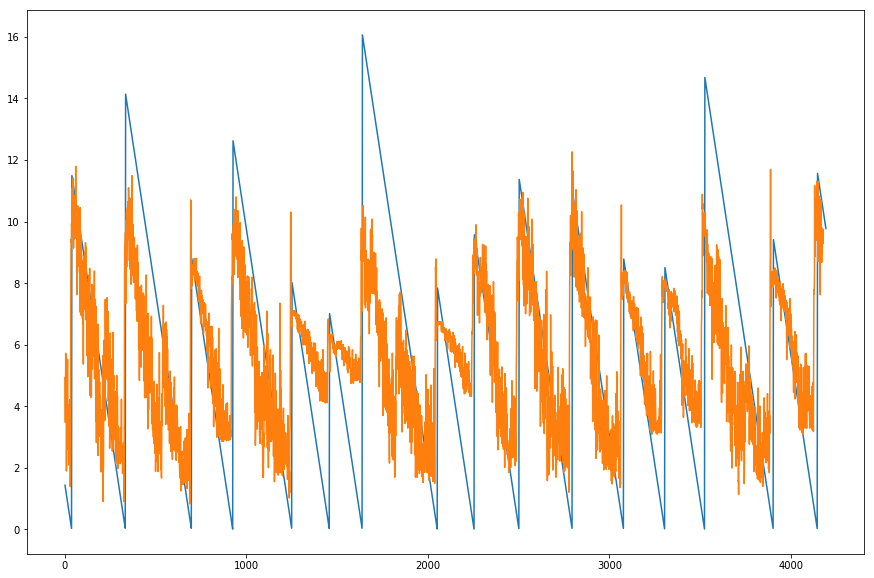

In [28]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(train_y_eliminated)
ax.plot(oof_lgb)

In [210]:
mean_absolute_error(train_y_eliminated,oof_cat)

2.08527360619977

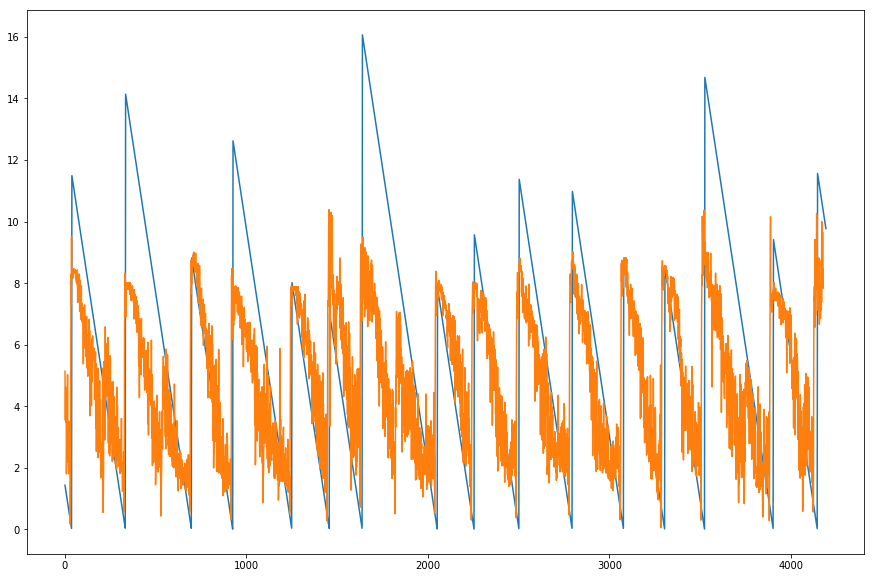

In [211]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(train_y_eliminated)
ax.plot(oof_cat)

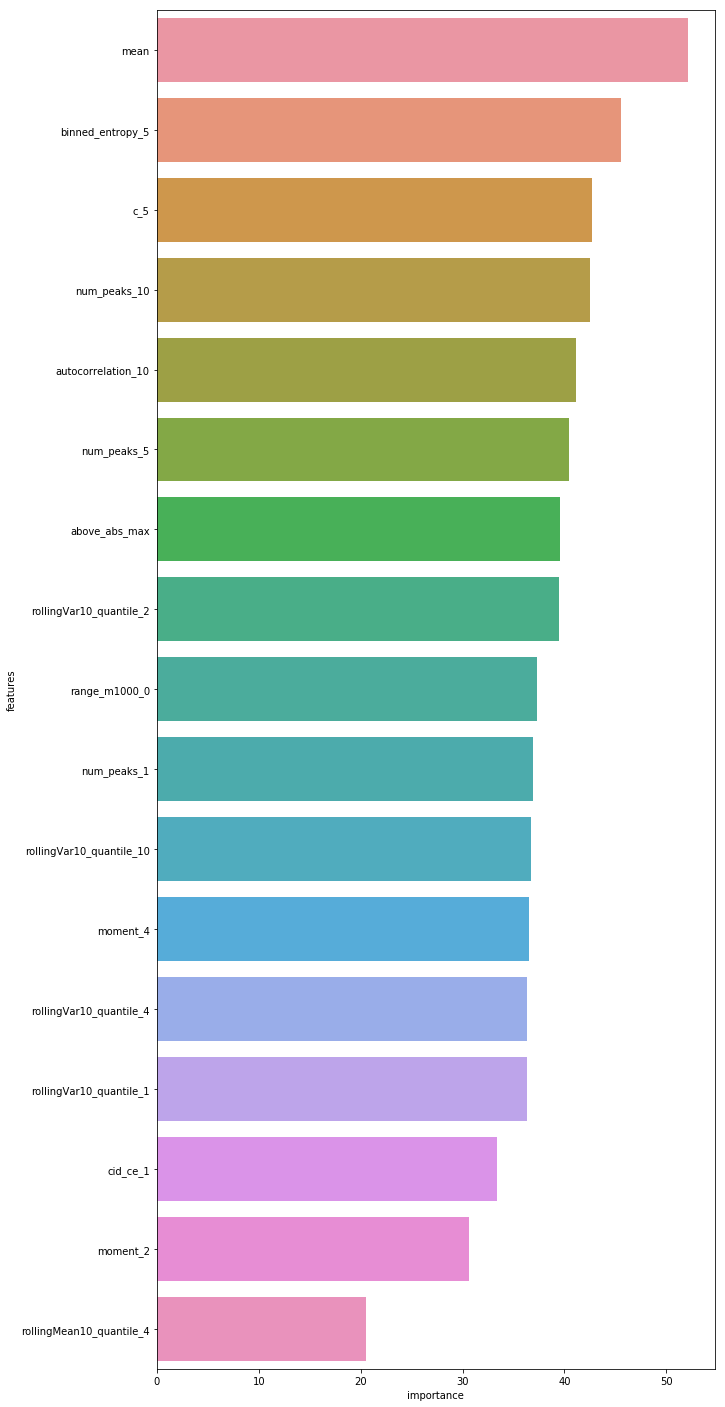

In [251]:
features_importance["importance"] = features_importance["importance"]/16
# predictions["time_to_failure"] = predictions["time_to_failure"]/5

plt.figure(figsize=(10,25))
ax = sns.barplot(x="importance", y="features", data=features_importance.sort_values(by="importance",ascending=False))


In [ ]:
final_pred_lgb = predictions_lgb.copy()
final_pred_lgb["time_to_failure"] = predictions_lgb["time_to_failure"]/16
final_pred_lgb.to_csv("../submissions/quekewise/lgb_sc_17_"+now.strftime("%d-%m-%H-%M")+".csv",index=False)

final_pred_cat = predictions_cat.copy()
final_pred_cat["time_to_failure"] = predictions_cat["time_to_failure"]/16
final_pred_cat.to_csv("../submissions/quekewise/cat_sc_17_"+now.strftime("%d-%m-%H-%M")+".csv",index=False)

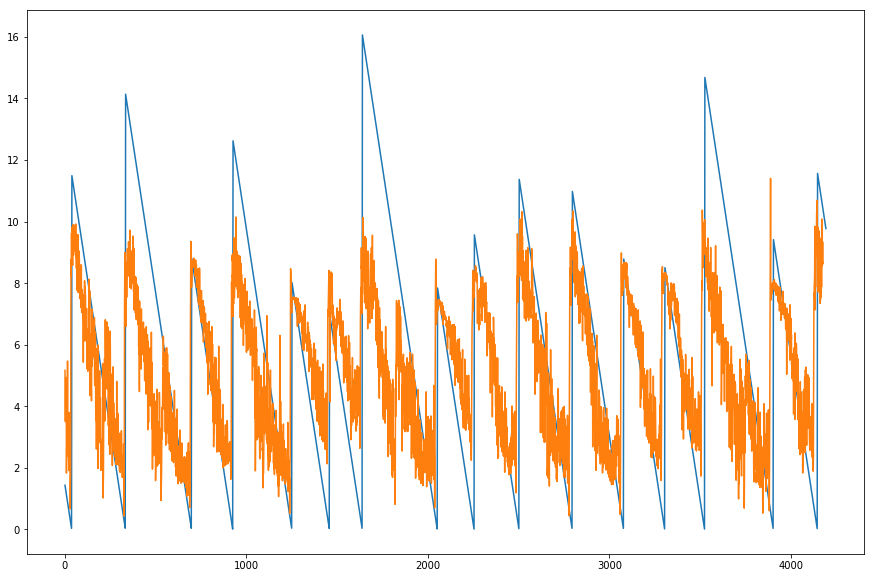

In [239]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(train_y_eliminated)
ax.plot((oof_cat+oof_lgb)/2)

In [240]:
mean_absolute_error(train_y_eliminated,(oof_cat+oof_lgb)/2) 

2.013739923550992

In [269]:
#mask {reg_scaled_nr-features_date.csv}
import datetime
now = datetime.datetime.now()
pd.DataFrame(oof_cat).to_csv("../oof/quekewise/cat_sc_17_"+now.strftime("%d-%m-%H-%M")+".csv",index=False)
pd.DataFrame(oof_lgb).to_csv("../oof/quekewise/lgb_sc_17_"+now.strftime("%d-%m-%H-%M")+".csv",index=False)

num_peaks_10               -0.783019
range_m1000_0              -0.777273
rollingVar10_quantile_2    -0.768590
rollingVar10_quantile_4    -0.757927
rollingVar10_quantile_1    -0.750589
rollingVar10_quantile_10   -0.716972
above_abs_max              -0.264396
moment_2                   -0.146196
moment_4                   -0.123523
binned_entropy_5            0.011568
mean                        0.149727
rollingMean10_quantile_4    0.506336
autocorrelation_10          0.531097
c_5                         0.681354
cid_ce_1                    0.693370
num_peaks_1                 0.745742
num_peaks_5                 0.815420
dtype: float64